### Student Information
Name: 鄭宗元

Student ID: 111065428

GitHub ID: yurisoba

Kaggle name: yurisoba

Kaggle private scoreboard snapshot:

[Snapshot](img/pic0.png)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the DM2023-Lab2-master. You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2) regarding Emotion Recognition on Twitter by this link https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Dec. 27th 11:59 pm, Wednesday)_. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Dec. 31th 11:59 pm, Sunday)__. 

# Preamble

In [149]:
%load_ext autoreload
%load_ext jupyter_spaces
%autoreload 2

import os

import gensim.downloader as gensim_dl
import keras
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.express as px

from keras.callbacks import CSVLogger
from keras.models import Model
from keras.layers import Input, Dense, ReLU, Softmax
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

from nltk.corpus import stopwords

stops = set(stopwords.words(("english")))
def stop(a_str: str) -> str:
    """
    Heuristically remove terms from string, returns a new string with remaining terms.
    Rules:
    - not in stop words list
    - does not contain number
    """
    global stops
    r = []
    a = a_str.split()
    for t in a:
        is_not_stop = t.lower() not in stops
        has_no_number = not any([str(digit) in t for digit in (0,1,2,3,4,5,6,7,8,9)])
        if all([is_not_stop, has_no_number]):
            r.append(t)
    return " ".join(r)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_spaces extension is already loaded. To reload it, use:
  %reload_ext jupyter_spaces


In [16]:
train_df = pd.concat([pd.read_csv(
        os.path.join("data", "semeval", "train",
                     f"{emo}-ratings-0to1.train.txt"),
        sep="\t", header=None,
        names=("id", "text", "emotion", "intensity")
    ) for emo in ("anger", "sadness", "fear", "joy")
], ignore_index=True)

test_df = pd.concat([pd.read_csv(
        os.path.join("data", "semeval", "dev",
                     f"{emo}-ratings-0to1.dev.gold.txt"),
        sep="\t", header=None,
        names=("id", "text", "emotion", "intensity")
    ) for emo in ("anger", "sadness", "fear", "joy")
], ignore_index=True)

# shuffle
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

# Exercise 1

In [44]:
%%space ex1

def plot_freq(df: pd.DataFrame, title: str):
    cv = CountVectorizer()
    counts = cv.fit_transform(
        df.apply(lambda x: stop(x["text"]), axis=1)
    )
    tf_list = np.asarray(counts.sum(axis=0))[0]
    tf_tuples = sorted(enumerate(tf_list), key=lambda x:x[1], reverse=True)
    px.bar(x=[cv.get_feature_names_out()[idx] for idx, _ in tf_tuples[:30]],
           y=[count for _, count in tf_tuples[:30]],
           title=title,
           ).show()
    
plot_freq(train_df, "top-30 for train_df")
plot_freq(test_df, "top-30 for test_df")


# Exercise 2

In [50]:
%%space ex2

train_tf1k = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize)
train_tf = train_tf1k.fit_transform(train_df.apply(lambda x: stop(x["text"]), axis=1))

train_tf1k.get_feature_names_out()[100:110]


/home/ben/dm2023-lab2/.venv/lib64/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



array(['best', 'bet', 'better', 'beyond', 'big', 'biggest', 'bill',
       'birthday', 'bit', 'bitch'], dtype=object)

# Exercise 3
![ex3.png](ex3.png)

## Interpretation
`fear` and `anger` is frequently misclassified as each other.


# Exercise 4

In [61]:
train_processed = train_df["text"].apply(stop)
bow500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize)
bow500.fit(train_processed)

x_train = bow500.transform(train_processed)
y_train = train_df["emotion"]

x_test =  bow500.transform(test_df["text"].apply(stop))
y_test = test_df["emotion"]


/home/ben/dm2023-lab2/.venv/lib64/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [62]:
%%space ex4

nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)

print(classification_report(y_true=y_test, y_pred=y_pred))


              precision    recall  f1-score   support

       anger       0.82      0.73      0.77        84
        fear       0.76      0.85      0.80       110
         joy       0.78      0.76      0.77        79
     sadness       0.71      0.70      0.71        74

    accuracy                           0.77       347
   macro avg       0.77      0.76      0.76       347
weighted avg       0.77      0.77      0.77       347


# Exercise 5
Because Naive Bayes is not a tree, tree is bad.
Why tree is bad?
You see: GPT is good, is GPT a tree? No.
Thus we can prove that, tree=not good, not tree=good.

# Exercise 6

In [66]:
%%space ex6

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

ey_train = keras.utils.to_categorical(label_encoder.transform(y_train))
ey_test = keras.utils.to_categorical(label_encoder.transform(y_test))

model_input = Input(shape=(x_train.shape[1]))
X_W1 = Dense(units=64)(model_input)
H1 = ReLU()(X_W1)

H1_W2 = Dense(units=64)(H1)
H2 = ReLU()(H1_W2)

H2_W3 = Dense(units=len(label_encoder.classes_))(H2)
model_output = Softmax()(H2_W3)

model = Model(inputs=(model_input,), outputs=(model_output,))
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=("accuracy",))

history = model.fit(x_train, ey_train,
                    epochs=25,
                    batch_size=32,
                    callbacks=CSVLogger("training_log.csv"),
                    validation_data = (x_test, ey_test))
print("training finish")

Epoch 1/25
113/113 [==============================] - 0s 2ms/step - loss: 1.3204 - accuracy: 0.3778 - val_loss: 1.2352 - val_accuracy: 0.5072
Epoch 2/25
113/113 [==============================] - 0s 2ms/step - loss: 0.9081 - accuracy: 0.6875 - val_loss: 0.7313 - val_accuracy: 0.7493
Epoch 3/25
113/113 [==============================] - 0s 1ms/step - loss: 0.4911 - accuracy: 0.8262 - val_loss: 0.6230 - val_accuracy: 0.7493
Epoch 4/25
113/113 [==============================] - 0s 1ms/step - loss: 0.3610 - accuracy: 0.8671 - val_loss: 0.6345 - val_accuracy: 0.7378
Epoch 5/25
113/113 [==============================] - 0s 2ms/step - loss: 0.2929 - accuracy: 0.8890 - val_loss: 0.6492 - val_accuracy: 0.7349
Epoch 6/25
113/113 [==============================] - 0s 2ms/step - loss: 0.2456 - accuracy: 0.9059 - val_loss: 0.6909 - val_accuracy: 0.7291
Epoch 7/25
113/113 [==============================] - 0s 1ms/step - loss: 0.2127 - accuracy: 0.9253 - val_loss: 0.7361 - val_accuracy: 0.7233
Epoch 

In [71]:
%%space ex6_csv

training_log = pd.read_csv("training_log.csv")

px.line(data_frame=training_log,
        x="epoch",
        y=["accuracy", "val_accuracy"],
        title="Accuracy per epoch").show()
px.line(data_frame=training_log,
        x="epoch",
        y=["loss", "val_loss"],
        title="Loss per epoch").show()


We can see that validation accuracy peaked at `epoch=2` (and validation loss is the lowest too), the quality degradation of the model after second epoch signals overfitting of the model.

# Exercise 7

In [147]:
%%space ex7

gl_model = gensim_dl.load("glove-twitter-25")

vmap = [0 for w in bow500.get_feature_names_out()]
for i, w in enumerate(bow500.get_feature_names_out()):
    try:
        vmap[i] = gl_model.get_vector(w)
    except:
        vmap[i] = np.zeros(25)

sv_train = [None] * x_train.shape[0]
for row in range(x_train.shape[0]):
    sent_vec = np.zeros(25)
    _, cols = x_train[row].nonzero()
    for idx in cols:
        sent_vec += vmap[idx]
    if len(cols) > 0:
        sent_vec = sent_vec/len(cols)
    sv_train[row] = sent_vec

display(len(sv_train))
display(sv_train[0])

3613

array([-0.19418367,  0.05949332,  0.29227866, -0.72142998, -0.08061167,
        0.34375333,  1.34350997, -0.28448331, -0.20801999, -0.61649667,
       -0.25202667,  0.41601332, -2.67186666,  0.62259668,  0.70597665,
       -0.61227334, -0.00620831, -0.10583333, -0.50135669, -0.01103333,
       -0.75477333, -0.04819667,  0.10464667, -0.34823333,  0.25901669])

# Exercise 8

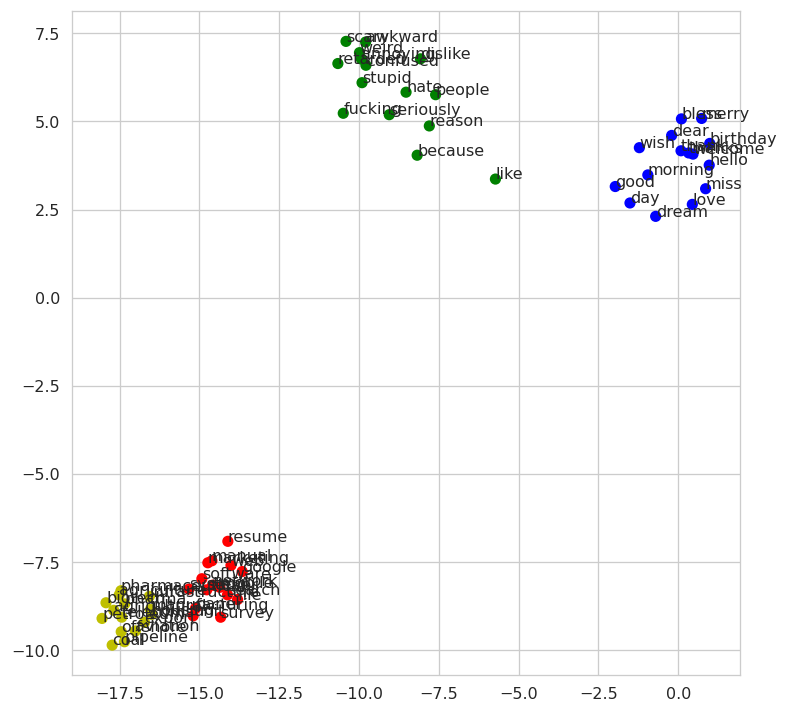

In [151]:
%%space ex8

gl_model = gensim_dl.load("glove-twitter-25")

target_words = [w for tw in ("happy", "angry", "data", "mining") 
                 for w, _ in gl_model.most_similar(tw, topn=15)]

cn = 15
color = ["b"] * cn + ["g"] * cn + ["r"] * cn + ["y"] * cn

size = 200
target_size = len(target_words)
all_word = list(gl_model.index_to_key)
word_train = target_words + all_word[:size]
X_train = gl_model[word_train]

tsne = TSNE(n_components=2, metric="cosine", random_state=28)

X_tsne = tsne.fit_transform(X_train)

plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0), textcoords="offset points")
plt.show()